<a href="https://colab.research.google.com/github/PGBeermann/DExperimental/blob/main/FenolesAnalisis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MODELO PARA LA DEGRADACION DE FENOLES EN MEDIO LIQUIDO

In [1]:
import numpy as np
from numpy import diff
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import odeint

DEFINICIÓN DE LAS FUNCIONES DEL MODELO

A=concentracion de fenol en el filtrado

B=concentración de fenol en la biomasa

$B_m=k_6-k_5*\exp(-k_7*(t-14.97)^2)$



$\mu=k_3*\exp(-k_4*(t-7.5)^2)$

aplicando las ecuaciones del equilibrio de adsorción y la cinética de degradación del fenol tenemos

$\frac{\delta A}{\delta t}=-k_a*A*(1-\frac{B}{B_m})+k_d*\frac{B}{B_m}$

$\frac{\delta B}{\delta t}=k_a*A*(1-\frac{B}{B_m})-k_d*\frac{B}{B_m}-\mu*B$

In [12]:
def f(C,t,ka,kd,k3,k4,k5,k6,k7):
    A=C[0]     #Concentración de fenol en el filtrado
    B=C[1]     #Concentración de fenol en la biomasa
    
    #MODELO CINÉTICO
    
    Bm=k6-k5*np.exp(-k7*(t-14.97)**2)        #función que simula el comportamiento de Bm(t)
    
    mu=k3*np.exp(-k4*(t-7.5)**2)             #función que simula el cambio de la pendiente de velocidad de la degradación de fenoles
    
    dBdt=ka*A*(1-B/Bm)-kd*B/Bm-mu*B
    dAdt=-ka*A*(1-B/Bm)+kd*B/Bm
         
    return np.array([dAdt,dBdt])



    #CÁLCULO DEL RESIDUAL
def residual(XR):
    X1=tuple(XR)
    
    y=odeint(f,C0,texp,args=X1)
    
    sum=np.sum((y[:,0]-filt)**2)+np.sum((y[:,1]-bio)**2)
    
  
    return sum


# Datos experimentales

Se dividió las concentraciones entre 1000 para mejorar el desempeño del proceso de optimización

In [3]:
texp0=np.array([4,4,4,8,8,8,14,14,14,21,21,21,29,29,29])
texp1=np.array([0,0,0,4,4,4,8,8,8,14,14,14,21,21,21,29,29,29])
filt0=np.array([1920,1680,1888,1744,1552,1680,1600,1520,1552,1640,1440,1540,1240,1400,1320,1285,1300,1175])
bio0=np.array([853.3466, 814.0853, 848.4916,806.66,836.66,859.99,769.99,769.99,773.33,413.33,420,356.66,683.33,729.99,663.33,779.99,783.33,729.99])

filt0=filt0/1000
bio0=bio0/1000
tot0m=filt0+bio0

# Datos experimentales promedio

Aquí se incluyen [Fenol] en el filtrado a t=0 y un valore de $[fenol]_{biomasa}$ a t=0 el cual se extrapoló con la linealización de la ecuación de Langmuir

In [4]:
texp=np.array([0,4,8,14,21,29])
filt=np.array([1829,1658.66,1557.33,1540.0,1320.0,1253.33])
bio=np.array([839,834.44,771.10,396.66,692.22,764.44])


filt=filt/1000
bio=bio/1000
total=filt+bio

# Optimización:

Parámetros iniciales para la optimización del modelo 

In [13]:
C0=np.array([1.829,0.839])

X0=np.array([0.1,0.1,0.1,0.1,0.1,1.303,0.0483])
bnds=((0,100.0),(0,100),(0,100.0),(0,100),(0,100),(0,100),(0,100))

res = minimize(residual, X0, method='TNC', bounds=bnds, tol=1e-6,options={'maxiter':500,'disp':False})
XX0=res.x
print("RESULTADO DE LA OPTIMIZACIÓN")
print(XX0)  
X1=tuple(XX0)
res=residual(X1)
print("Residual:",res)

RESULTADO DE LA OPTIMIZACIÓN
[0.4396472  0.33581303 0.08793823 0.02514136 0.68073704 1.25880794
 0.05409665]
Residual: 0.00915518790496757


# Gráficos

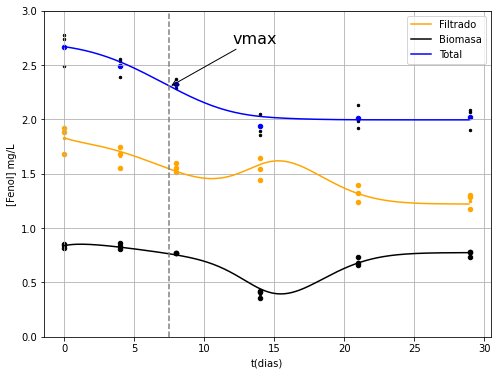

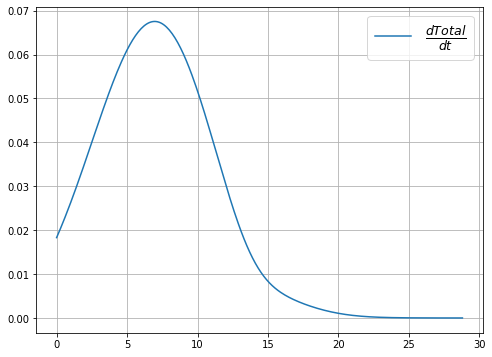

In [16]:
tcalc=np.arange(0,29,0.1)  
y=odeint(f,C0,tcalc,args=X1)
ytotal=y[:,0]+y[:,1]    
total=filt+bio
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(texp,filt,s=6,c='orange')
plt.scatter(texp,bio,s=6,c='black')
plt.scatter(texp,total,s=6,c='black')

plt.plot(tcalc,y[:,0],color="orange",label='Filtrado')
plt.plot(tcalc,y[:,1],color="black",label='Biomasa')
plt.plot(tcalc,ytotal,color="blue",label='Total')
plt.xlabel("t(dias)")
plt.ylabel("[Fenol] mg/L")
ax.set_ylim([0,3.0])

#Datos experimentales incluyendo filt(t=0) exp y bio(t=0) extrapolado
texp1=np.array([0,0,0,4,4,4,8,8,8,14,14,14,21,21,21,29,29,29])
filt0=np.array([1920,1680,1888,1744,1552,1680,1600,1520,1552,1640,1440,1540,1240,1400,1320,1285,1300,1175])
bio0=np.array([853.3466, 814.0853, 848.4916,806.66,836.66,859.99,769.99,769.99,773.33,413.33,420,356.66,683.33,729.99,663.33,779.99,783.33,729.99])

filt0=filt0/1000
bio0=bio0/1000
tot0=filt0+bio0
plt.scatter(texp1,filt0,s=20,c='orange')
plt.scatter(texp1,bio0,s=20,c='black')
plt.scatter(texp1,tot0,s=6,c='black')

#Datos Promedio
texp=np.array([0,4,8,14,21,29])
filt=np.array([1829,1658.66,1557.33,1540.0,1320.0,1253.33])/1000
bio=np.array([839,834.44,771.10,396.66,692.22,764.44])/1000
tot=filt+bio
plt.scatter(texp,tot,s=20.0,c='blue')

plt.axvline(x=7.5,color="grey", linestyle="--")
plt.annotate("vmax", xy=(7.5, 2.3), xytext=(12, 2.7),arrowprops=dict(arrowstyle="->"),fontsize=16)

plt.grid(True)
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
dx=0.1
dy = diff(ytotal)/dx
plt.plot(tcalc[0:-1],-dy,label=r'$\frac{dTotal}{dt}$')
plt.grid(True)
plt.legend(fontsize=18)
plt.show()

# ANALISIS DE LA OPTIMIZACIÓN

1. Del gráfico para la degradación de fenoles totales podemos ver que la velocidad máxima se alcanza a los 7.0 dias (ver gráfico de $\frac{dTotal}{dt}~~ vs~~ t$). Después del día 15 se hace imperceptible la actividad enzimática.
2. Existe un equilibrio entre el fenol disuelto en el filtrado y el fenol adsorbido u ocluido en la biomasa, el cual sigue el comportamiento de la isoterma de Langmuir. 
3. Dado que entre los dias 8-21 se da una disminución en la biomasa por factores característicos del crecimiento de este tipo de hongos, el factor $B_m$, que corresponde a la capacidad de adsorción de la biomasa, disminuye durante este periodo. Se observa entonces una disminución de la concentración de fenoles adsorbidos y un aumento en la concentración de fenoles en el filtrado. 
4. Una vez se recupera la biomasa por crecimiento posterior, se observa nuevamente el aumento en la cantidad de fenoles adsorbidos por el aumento de $B_m$. 
5. Según los datos la biomasa que crece después del dia 15, parece no tener las propiedades enzimáticas para la degradación de fenoles que tenía la biomasa inicial, por lo que durante este periodo no se observa degradación de fenoles.

array([[1.       , 0.5899404],
       [0.5899404, 1.       ]])

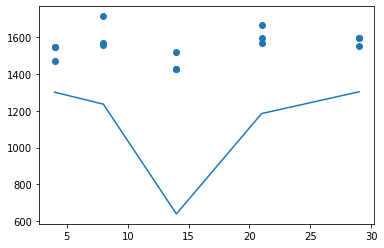

In [32]:
protCV=np.array([73.5,77.5,77.5,85.75,78.5,78.0,76.0,71.5,71.5,79.75,78.5,83.5,77.75,79.75,79.75])
t=np.array([4,4,4,8,8,8,14,14,14,21,21,21,29,29,29])
yy=1303.6-694.6*np.exp(-0.0483*(t-14.95)**2)
plt.scatter(t,protCV*20)
plt.plot(t,yy)

np.corrcoef(yy,protCV)


6. Entre la proteína en la biomasa con vinaza y la concentración de fenoles adsorbidos existe un coeficiente de correlación de 0.5899404. La disminución de la capacidad de adsorción de la biomasa pude deberse, aparte de la disminución observada en la cantidad de proteína a otros factores como son cambios de pH, cambios en la estructura de la proteína que pueden causar la liberación de fenoles al medio sin la correspondiente disminución de la biomasa, entre otros factores.